In [5]:
import numpy as np
from scipy import stats 
import pandas as pd
import matplotlib as mpl

from tqdm.notebook import tqdm
import cdpm
from sklearn.preprocessing import normalize
import pandas_datareader as pd_reader
from itertools import combinations

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [6]:
cdpm.__version__

'0.12.02-py37_0'

In [7]:
%matplotlib inline
mpl.style.use('seaborn-talk')
#np.set_printoptions(precision=5, suppress=True, floatmode='fixed')

In [8]:
filename_id = 'varmixture'
forecast_type = 'cdpm'
#mode = '.tmp'
mode = ''
#univariate_name = 'Consumption'

In [9]:
filename = f'../results/{filename_id}_{forecast_type}{mode}.hdf'

In [10]:
results = cdpm.read_results(filename)

In [11]:
data = results['data']

In [12]:
beta_draws = results['beta']
comp_cov_draws = results['comp_cov']
if 'cluster_identity' in results:
    cluster_identity_draws = results['cluster_identity']
    stick_draws = results['sticks']
    trans_mat_draws = results['trans_mat']
    cov_mean_draws = results['cov_mean']
    beta_mean_draws = results['beta_mean']
regressor = results['regressor']
regressand = results['regressand']
data = results['data']

In [13]:
num_forecast_draws = 5000

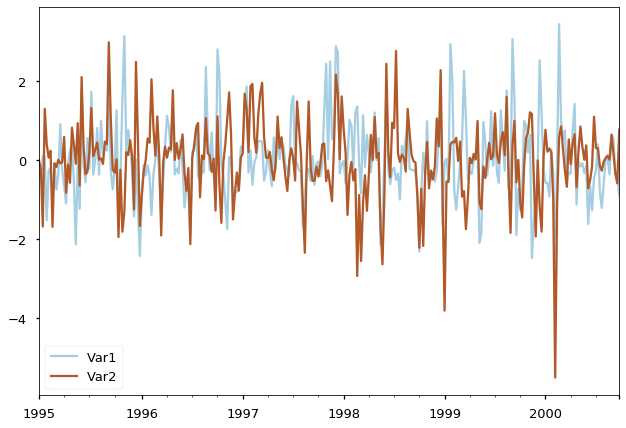

In [14]:
data.plot(colormap=mpl.cm.get_cmap('Paired'))

## results

In [15]:
percentiles = [1,5, 25, 50, 75, 95, 99]

In [16]:
if 'cluster_identity' in results:
    state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)
    trans_mat_mean = pd.DataFrame(normalize(np.mean(np.nan_to_num(trans_mat_draws), axis=0),norm='l1'))
    print(trans_mat_mean.iloc[:5, :5])

          0         1         2         3         4
0  0.185600  0.160858  0.077311  0.062744  0.054621
1  0.215834  0.133005  0.111999  0.062930  0.048756
2  0.222822  0.111432  0.092591  0.098100  0.049742
3  0.222419  0.110639  0.080509  0.079432  0.081555
4  0.219283  0.107936  0.076198  0.063198  0.071810


In [156]:
if forecast_type == 'cdpm':
    stationary_dist = cdpm.compute_stationary_distribution(trans_mat_draws, progress_bar=tqdm)
    print(stationary_dist.mean().cumsum().head())



0    0.112877
1    0.169822
2    0.220954
3    0.268533
4    0.311174
dtype: float64


## parameter estimates

In [157]:
comp_cov_mean = np.nanmean(comp_cov_draws, axis=0) 

if 'cluster_identity' in results:

    for idx, arr in enumerate(comp_cov_mean[:3]):
        df_to_print = pd.DataFrame(arr, columns=data.columns, index=data.columns).T
        print(f"Comp {idx}:\n\n {df_to_print}\n")
else:
    df_to_print = pd.DataFrame(comp_cov_mean, columns=data.columns, index=data.columns).T
    print(df_to_print)   

Comp 0:

           Var1      Var2
Var1  0.338410  0.076594
Var2  0.076594  0.135718

Comp 1:

           Var1      Var2
Var1  0.281818  0.059419
Var2  0.059419  0.118658

Comp 2:

           Var1      Var2
Var1  0.282061  0.051342
Var2  0.051342  0.106767



In [158]:
if 'cov_mean' in results:
    df_to_print = pd.DataFrame(np.mean(np.nanmean(cov_mean_draws, axis=0), axis=0), columns=data.columns,
                               index=data.columns)
    print(df_to_print)   

          Var1      Var2
Var1  0.214797  0.027477
Var2  0.027477  0.069336


In [159]:
comp_coeff_mean = np.nanmean(beta_draws, axis=0) 

if 'cluster_identity' in results:

    for idx, arr in enumerate(comp_coeff_mean[:3]):
        df_to_print = pd.DataFrame(arr, columns=data.columns, index=regressor.columns).T
        print(f"Comp {idx}:\n\n {df_to_print}\n")
else:
    df_to_print = pd.DataFrame(comp_coeff_mean, columns=data.columns, index=regressor.columns).T
    print(df_to_print)   

Comp 0:

       Intercept      Var1      Var2
Var1  -0.004251  0.625801 -0.347158
Var2  -0.060397 -0.069365  0.836040

Comp 1:

       Intercept      Var1      Var2
Var1  -0.001270  0.610378 -0.328321
Var2  -0.048139 -0.095888  0.823526

Comp 2:

       Intercept      Var1      Var2
Var1   0.046638  0.611501 -0.330823
Var2   0.056061 -0.053693  0.768083



In [160]:
if 'beta_mean' in results:
    df_to_print2 = pd.DataFrame(np.nanmean(beta_mean_draws, axis=0), columns=data.columns,
                               index=regressor.columns).T
    print(df_to_print2)   

      Intercept      Var1      Var2
Var1   0.032413  0.618904 -0.332071
Var2   0.052213 -0.061902  0.841675


In [161]:
if 'cluster_identity' in results:
    mean_est, var_from_mean, innov_var  = cdpm.compute_mean_and_var(regressor, regressand,
                                                                trans_mat_draws[-num_forecast_draws:],
                                                                cluster_identity_draws.iloc[-num_forecast_draws:],
                                                                beta_draws[-num_forecast_draws:], 
                                                                comp_cov_draws[-num_forecast_draws:],
                                                                progress_bar=tqdm)
else:
    mean_est = pd.DataFrame(regressor @ comp_coeff_mean).shift(-1).dropna()
    mean_est.columns = regressand.columns
    var_from_mean = pd.DataFrame(np.zeros(mean_est.shape), index=mean_est.index, columns=mean_est.columns)
    innov_var = pd.DataFrame(np.tile(np.diag(comp_cov_mean), (mean_est.index.shape[0], 1)),
                            index=mean_est.index, columns=mean_est.columns)

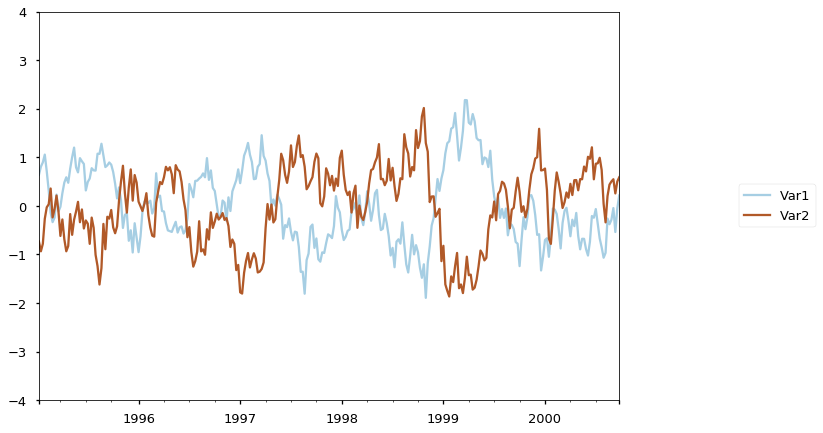

In [163]:
mean_fig, mean_ax = mpl.pyplot.subplots(1,1)
mean_est.plot(ax=mean_ax, colormap=mpl.cm.get_cmap('Paired'))
mean_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
mean_ax.set_ylim(-4,4)
lower_y, upper_y = mean_ax.get_ylim()

#mean_ax.fill_between(x=recessions.index, y1=recessions.apply(
#             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
mean_ax.set_xlabel("")

mean_fig.savefig(f'../results/{forecast_type}/{filename_id}_mean_forecast{mode}.pdf',
                 transparent=True, bbox_inches='tight', pad_inches=0)

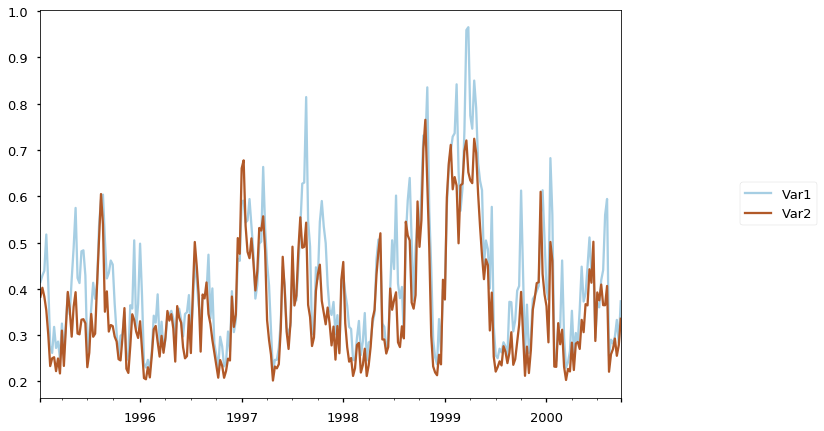

In [164]:
std_from_mean_fig, std_from_mean_ax = mpl.pyplot.subplots(1,1)
var_from_mean.apply(np.sqrt).sort_index(axis=1).plot(ax=std_from_mean_ax, colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = std_from_mean_ax.get_ylim()
#std_from_mean_ax.fill_between(x=recessions.index, y1=recessions.apply(
#             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
std_from_mean_ax.set_xlabel("")
std_from_mean_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

std_from_mean_fig.savefig(f'../results/{forecast_type}/{filename_id}_std_from_mean{mode}.pdf', 
                          transparent=True, bbox_inches='tight', pad_inches=0)

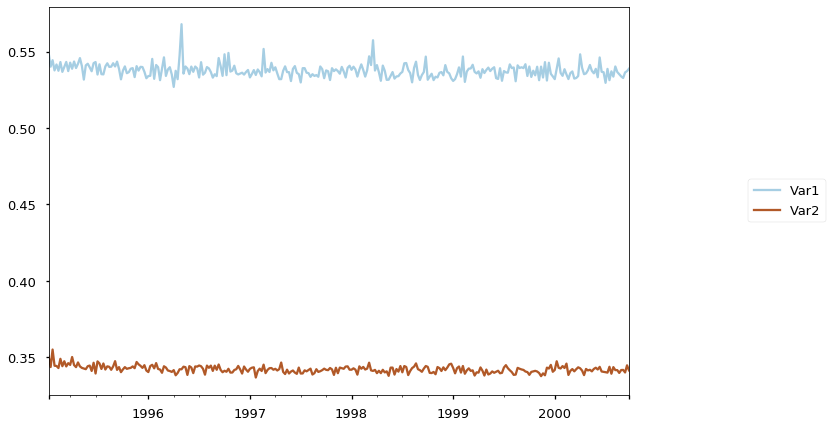

In [165]:
std_from_var_fig, std_from_var_ax = mpl.pyplot.subplots(1,1)

innov_var.apply(np.sqrt).sort_index(axis=1).plot(
    ax=std_from_var_ax, colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = std_from_var_ax.get_ylim()
#std_from_var_ax.fill_between(x=recessions.index, y1=recessions.apply(
#             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
std_from_var_ax.set_xlabel("")
std_from_var_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

std_from_var_fig.savefig(f'../results/{forecast_type}/{filename_id}_std_from_var{mode}.pdf',
                         transparent=True, bbox_inches='tight', pad_inches=0)

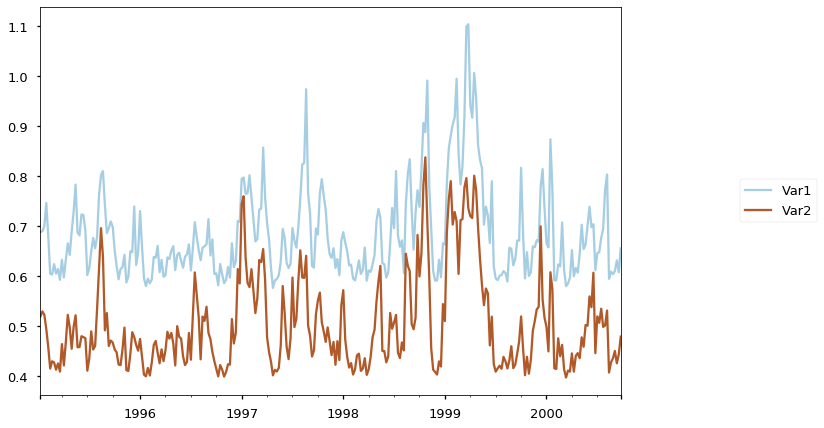

In [166]:
std_total_fig, std_total_ax = mpl.pyplot.subplots(1,1)

(innov_var + var_from_mean).apply(np.sqrt).sort_index(axis=1).plot(ax=std_total_ax,
                                                                   colormap=mpl.cm.get_cmap('Paired'))
    
lower_y, upper_y = std_total_ax.get_ylim()
#std_total_ax.fill_between(x=recessions.index, y1=recessions.apply(
#             lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.25)
std_total_ax.set_xlabel("")
std_total_ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

std_total_fig.savefig(f'../results/{forecast_type}/{filename_id}_std_total{mode}.pdf',
                      transparent=True, bbox_inches='tight', pad_inches=0)

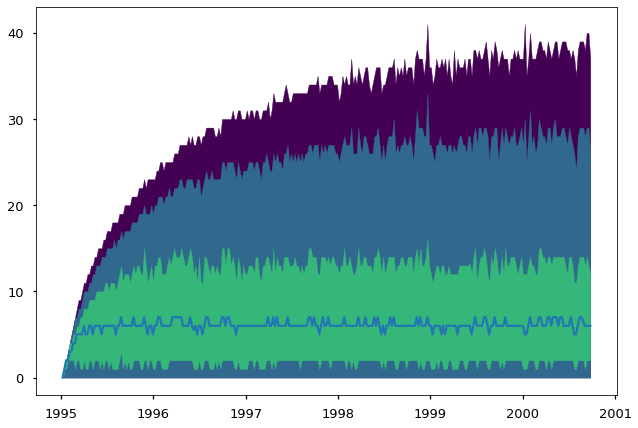

In [167]:
if 'cluster_identity' in results:
    cluster_id_fig, cluster_id_ax = mpl.pyplot.subplots(1,1)
    cdpm.fan_plot(data=pd.DataFrame(cluster_identity_draws.T, index=data.index[1:]), ax=cluster_id_ax, 
                  percentiles=percentiles)

    lower_y, upper_y = cluster_id_ax.get_ylim()
    #cluster_id_ax.fill_between(x=recessions.index, y1=recessions.apply(
      #       lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
       #                   zorder=-10)
    cluster_id_ax.set_xlabel("")


    cluster_id_fig.savefig(f'../results/{forecast_type}/{forecast_type}_{filename_id}_cluster_id{mode}.pdf',
                       transparent=True,bbox_inches='tight', pad_inches=0)

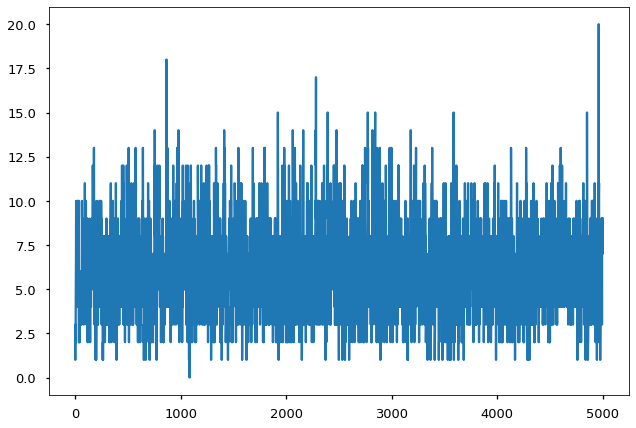

In [168]:
if 'cluster_identity' in results:

    data_cl = pd.DataFrame(cluster_identity_draws.T, index=data.index[1:])
    data_cl.median().plot()

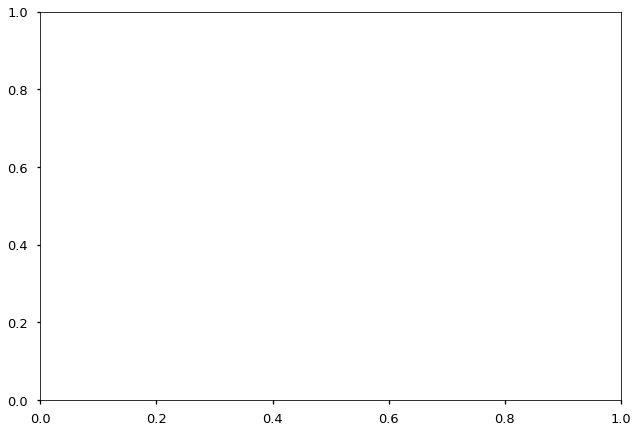

In [169]:
if 'cluster_identity' in results:
    mcluster_id_fig, mcluster_id_ax = mpl.pyplot.subplots(1,1)
    cdpm.fan_plot(data=pd.DataFrame(cluster_identity_draws.T, index=data.index[1:]), ax=cluster_id_ax, 
                  percentiles=[25, 50, 75])

    mlower_y, mupper_y = mcluster_id_ax.get_ylim()
   # cluster_id_ax.fill_between(x=recessions.index, y1=recessions.apply(
     #        lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
      #                    zorder=-10)
    mcluster_id_ax.set_xlabel("")

In [170]:
if 'cluster_identity' in results:
    posterior_cluster_probs = pd.DataFrame(np.column_stack([np.mean(cluster_identity_draws == idx, axis=0) 
                           for idx in np.unique(cluster_identity_draws)]), index=data.index[1:])

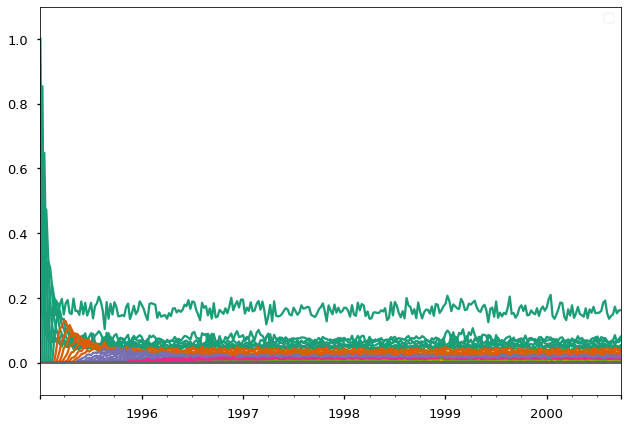

In [171]:
if 'cluster_identity' in results:
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    posterior_cluster_probs.plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([-.1,1.1])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
 #   cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
  #           lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
   #                       zorder=-10)
    cluster_probs_fig.savefig(f'../results/cdpm/{filename_id}_cluster_probs{mode}.pdf',
                              transparent=True,bbox_inches='tight', pad_inches=0)

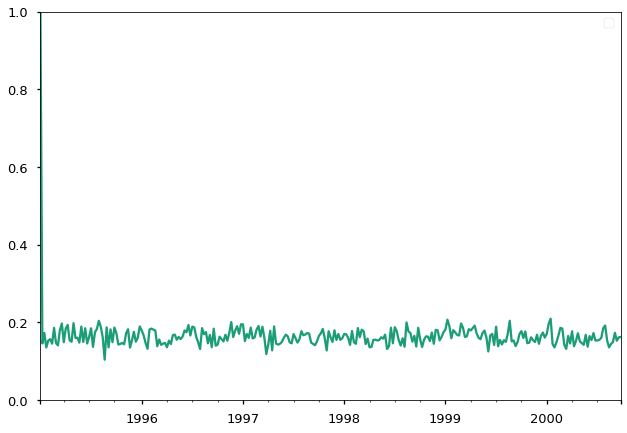

In [172]:
if 'cluster_identity' in results:
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    posterior_cluster_probs[0].plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([0.0,1.0])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
    #cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
     #        lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
      #                    zorder=-10)
    cluster_probs_fig.savefig(f'../results/cdpm/{filename_id}_1stcluster_probs{mode}.pdf',
                              transparent=True, bbox_inches='tight', pad_inches=0)
    

In [173]:
if 'cluster_identity' in results:
    remaining_cluster_probs = posterior_cluster_probs[1]+posterior_cluster_probs[2]+posterior_cluster_probs[3]+posterior_cluster_probs[4]

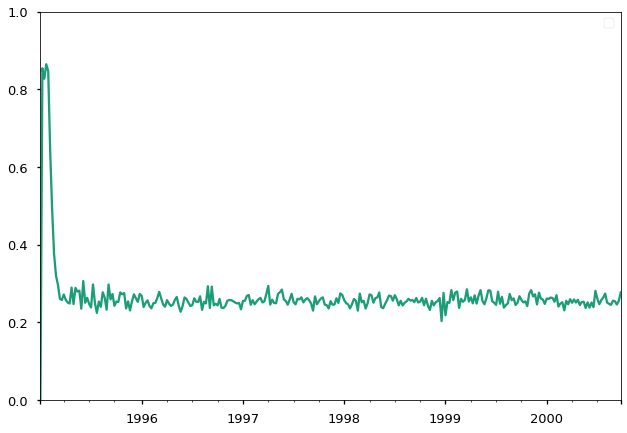

In [174]:
if 'cluster_identity' in results:
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    #posterior_cluster_probs[1].plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    remaining_cluster_probs.plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([0.0,1.0])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
    #cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
     #        lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
      #                    zorder=-10)
    cluster_probs_fig.savefig(f'../results/cdpm/{filename_id}_2ndcluster_probs{mode}.pdf',
                              transparent=True,bbox_inches='tight', pad_inches=0)

    

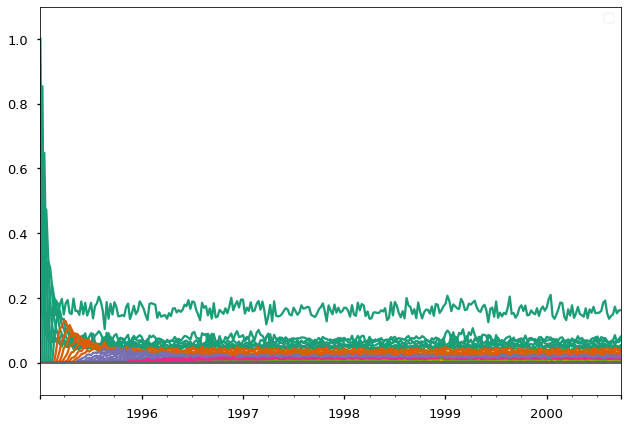

In [175]:
if 'cluster_identity' in results:
    cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
    posterior_cluster_probs.plot(ax=cluster_probs_ax, colormap=mpl.cm.get_cmap('Dark2'))
    cluster_probs_ax.set_ylim([-.1,1.1])
    cluster_probs_ax.legend("")
    lower_y, upper_y = 0, 1
  #  cluster_probs_ax.fill_between(x=recessions.index, y1=recessions.apply(
   #          lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
    #                      zorder=-10)
    cluster_probs_fig.savefig(f'../results/cdpm/{filename_id}_cluster_probs{mode}.pdf',
                              transparent=True,bbox_inches='tight', pad_inches=0)

## forecasting

In [17]:
if 'cluster_identity' in results:
    data_est_mat = cdpm.predict_draws(cluster_identity_draws, trans_mat_draws, beta_draws,comp_cov_draws,
                                   regressor, progress_bar=tqdm)
else:
    data_est_mat = cdpm.predict_ols(beta_draws=beta_draws,comp_cov_draws=comp_cov_draws,
                                         regressor=regressor, progress_bar=tqdm)

In [18]:
cdpm.__version__

'0.12.02-py37_0'

In [19]:
if 'cluster_identity' in results:

    correlation_series = []
    for name1, name2 in tqdm(list(combinations(data.columns, 2))):
    
        series1 = data_est_mat.loc[(slice(None), name1),:].reset_index('variable', drop=True)
        series2 = data_est_mat.loc[(slice(None), name2),:].reset_index('variable', drop=True)
    
        covariance = ((series1.transform(lambda x: x - np.mean(x), axis=1) 
                      * series2.agg(lambda x: x - np.mean(x), axis=1)).apply(np.mean, axis=1)) 
    
        correlation = (covariance / np.sqrt(np.var(series1, axis=1) * np.var(series2, axis=1))).to_frame()
        correlation.columns = [name1 + " , " + name2]
        
        correlation_series.append(correlation)
        
    correlations_df = pd.concat(correlation_series, axis=1)   

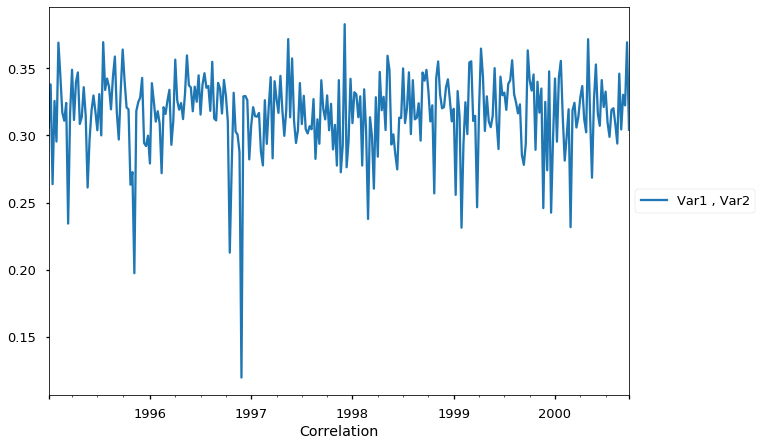

In [20]:
if forecast_type == 'cdpm':
    corr1_fig, corr1_ax = mpl.pyplot.subplots()
    correlations_df.plot(ax=corr1_ax)

    lower_y, upper_y = corr1_ax.get_ylim()
   # corr1_ax.fill_between(x=recessions.index, y1=recessions.apply(
    #         lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
     #        zorder=-10)
    corr1_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    corr1_ax.set_xlabel("Correlation")
    corr1_fig.savefig(f'../results/{forecast_type}/{filename_id}_time_varying_corr{mode}.pdf'.replace(" ", "_"),
                         transparent=True, bbox_inches='tight', pad_inches=0)

In [21]:
data_est_mat.head()

0         1         2         3         4     \
date       variable                                                     
1995-01-08 Var1      1.254216 -0.671314  0.255970  0.722350 -0.812592   
1995-01-15 Var1     -0.813602 -0.522321 -0.835444  1.348135 -0.190143   
1995-01-22 Var1      1.150887  0.825146  0.839354  0.841726  0.872221   
1995-01-29 Var1     -0.347147  0.706501  0.338766 -0.462404 -0.574276   
1995-02-05 Var1     -0.141069  1.790786 -2.108732  0.844246 -1.022892   

                         5         6         7         8         9     ...  \
date       variable                                                    ...   
1995-01-08 Var1      1.349288 -1.563657  1.366963 -0.395009 -0.361880  ...   
1995-01-15 Var1     -0.629743  1.417153 -0.412657 -1.724500  0.819147  ...   
1995-01-22 Var1      2.042267 -1.876036  1.301675 -0.254763  0.852299  ...   
1995-01-29 Var1      0.180183  1.984577 -0.243233 -0.165874 -2.586892  ...   
1995-02-05 Var1     -1.099935  0.907308 -0.050387 -0.402108 -0.941187  ...   

                         4990      4991      4992      4993      4994  \
date       variable                                                     
1995-01-08 Var1     -0.604429  0.776662 -2.070396 -0.318836  0.118283   
1995-01-15 Var1     -0.194871 -0.981701  2.783498 -1.076847  0.218826   
1995-01-22 Var1      0.770176 -2.449043  2.203386  0.299460  1.607732   
1995-01-29 Var1     -1.550990 -0.728337  1.288310 -2.329220  0.267892   
1995-02-05 Var1     -2.755264  0.182847 -1.046963 -1.176985  1.150191   

                         4995      4996      4997      4998      4999  
date       variable                                                    
1995-01-08 Var1     -0.181199 -1.200823 -1.495106  0.793437  0.418236  
1995-01-15 Var1      0.433324  2.628169  0.395621  1.268809 -0.437537  
1995-01-22 Var1      1.006677  0.010076  1.547496  1.661227  0.787433  
1995-01-29 Var1     -0.943906 -0.989808  0.555628  0.440478 -0.595374  
1995-02-05 Var1     -0.972062 -0.071467 -0.699737 -0.834904  0.498505  

[5 rows x 5000 columns]

In [22]:
univariate_forecast = data_est_mat.loc[(slice(None), 'Var1'),:].reset_index('variable', drop=True)
univariate_name = "Var1"

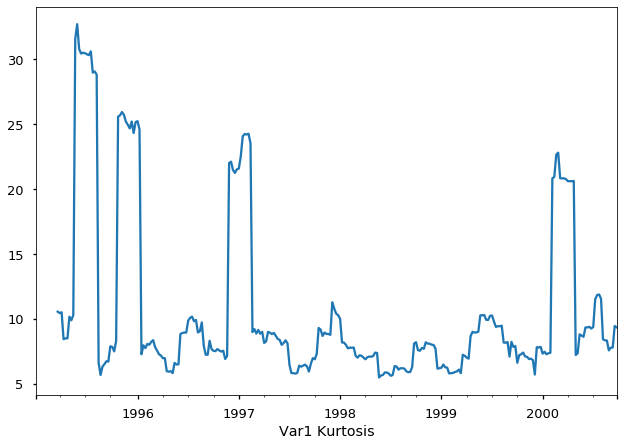

In [23]:
kurt_fig, kurt_ax = mpl.pyplot.subplots()
univariate_forecast.dropna(axis=1).agg(stats.kurtosis,
                                       fisher=False, axis=1).rolling(window=12).mean().plot(ax=kurt_ax)

lower_y, upper_y = kurt_ax.get_ylim()
#kurt_ax.fill_between(x=recessions.index, y1=recessions.apply(
 #            lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
  #                        zorder=-10)
kurt_ax.set_xlabel(f"{univariate_name} Kurtosis")
kurt_fig.savefig(f'../results/{forecast_type}/{filename_id}_{univariate_name}_kurt{mode}.pdf'.replace(" ", "_"),
                         transparent=True, bbox_inches='tight', pad_inches=0)

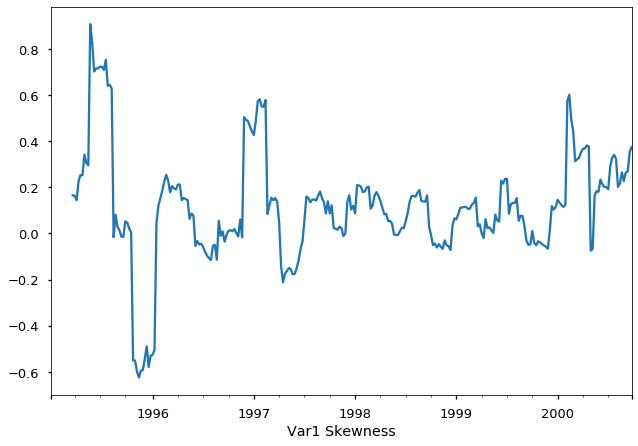

In [24]:
skew_fig, skew_ax = mpl.pyplot.subplots()
univariate_forecast.dropna(axis=1).agg(stats.skew, axis=1).rolling(window=12).mean().plot(ax=skew_ax)

lower_y, upper_y = skew_ax.get_ylim()
#skew_ax.fill_between(x=recessions.index, y1=recessions.apply(
 #            lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
  #                        zorder=-10)
skew_ax.set_xlabel(f"{univariate_name} Skewness")
skew_fig.savefig(f'../results/{forecast_type}/{filename_id}_{univariate_name}_skew{mode}.pdf'.replace(" ", "_"),
                         transparent=True, bbox_inches='tight', pad_inches=0)

In [25]:
filename_id

'varmixture'

In [26]:
data_est_mat.shape

(598, 5000)

In [27]:
data.columns = ['Var1', 'Var2']

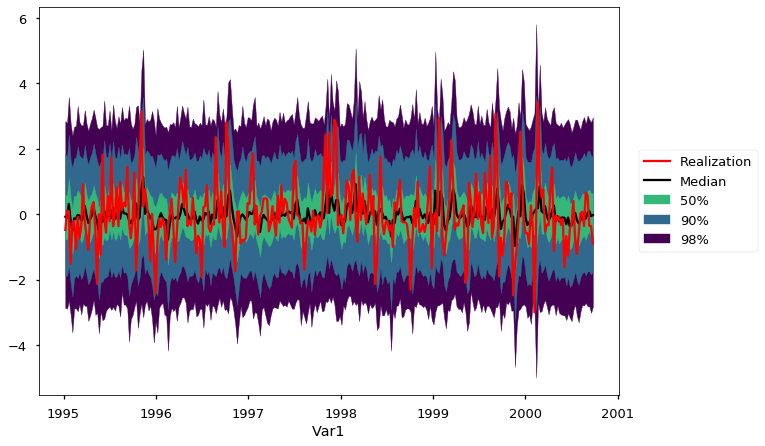

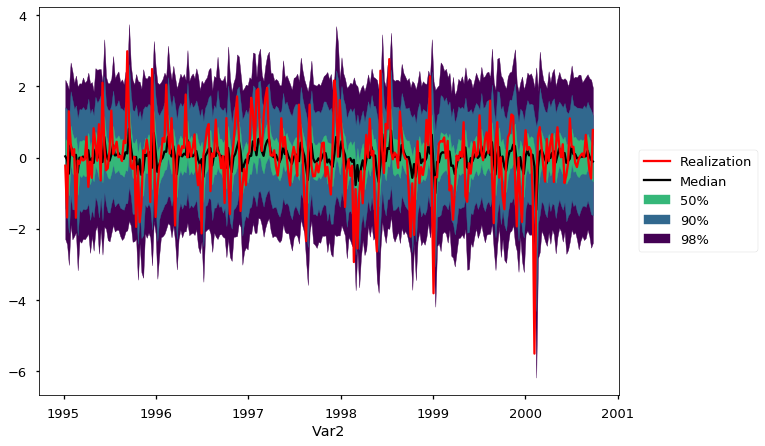

In [28]:
for col in regressand.columns:
    data_comparison_fig, data_comparison_ax = mpl.pyplot.subplots(1,1)
    data_comparison_ax.plot(regressand.index, regressand[col].values, color='red', label='Realization', 
                            zorder=10)
    _data = data_est_mat.loc[(slice(None), col), :].reset_index('variable', drop=True)
    cdpm.fan_plot(data=_data, ax=data_comparison_ax, percentiles=percentiles, color='black', 
                  labels=['Median'] + ['98%', '90%','50%'])

    data_comparison_ax.set_xlabel(col)
    lower_y, upper_y = data_comparison_ax.get_ylim()
    #data_comparison_ax.fill_between(x=recessions.index, y1=recessions.apply(
     #        lambda x: x * (upper_y - lower_y) + lower_y).values.ravel(), y2=lower_y, color='grey', alpha=.5,
      #                    zorder=-10)
    data_comparison_ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    
    filename_4_forecast = f'../results/{forecast_type}/{col}_{filename_id}_forecasts{mode}.pdf'.replace(" ", "_")
    data_comparison_fig.savefig(filename_4_forecast, transparent=True, frameone=False, bbox_inches='tight',
                                pad_inches=0)

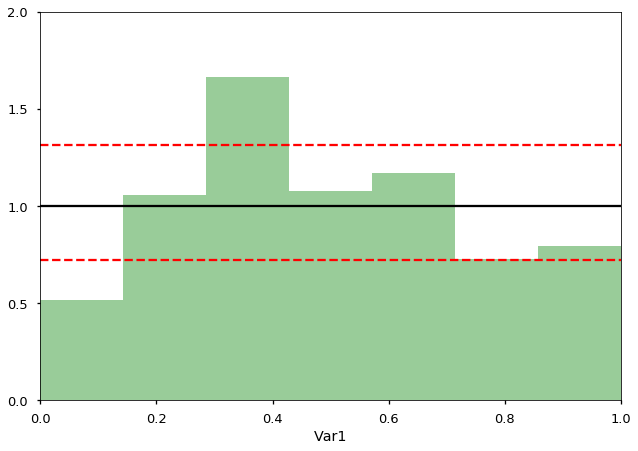

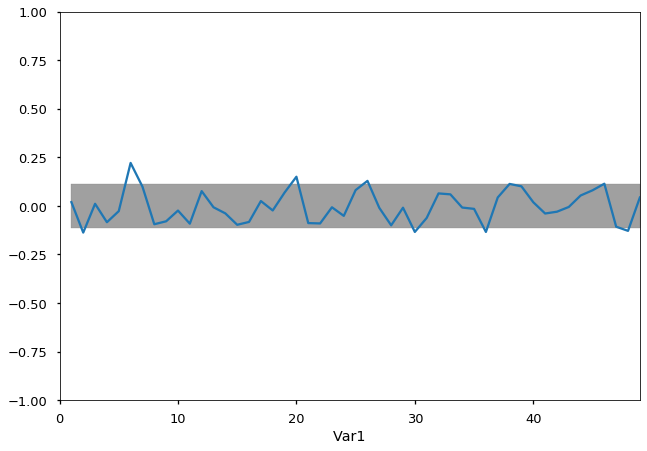

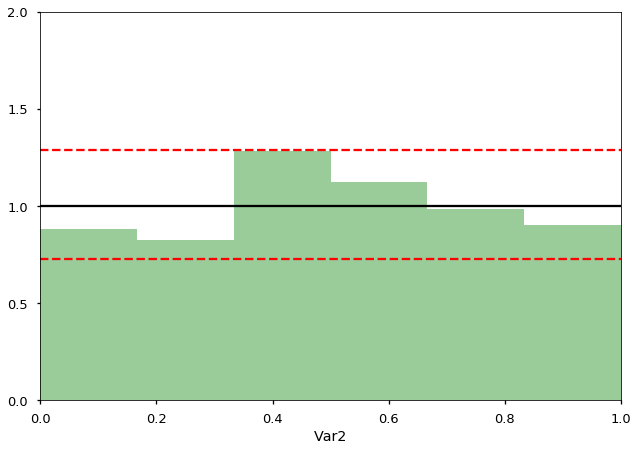

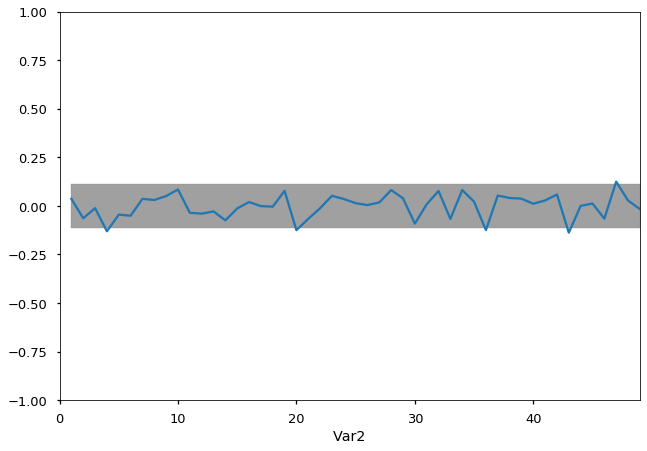

In [29]:
for col in regressand.columns:
    estimates = data_est_mat.loc[(slice(None), col), :].reset_index('variable', drop=True)

    pit = cdpm.probability_integral_transform(estimates, regressand[col])
    pit_fig, pit_ax = mpl.pyplot.subplots()
    cdpm.pit_plot(pit, ax=pit_ax, pct=.95, color='green')
    pit_ax.set_xlabel(col)
    pit_fig.savefig(f'../results/{forecast_type}/{col}_{filename_id}_pit{mode}.pdf'.replace(" ", "_"),
                    bbox_inches='tight', pad_inches=0, transparent=True)
    
    acf_fig, acf_ax = mpl.pyplot.subplots()
    acf_ax.set_xlabel(col)
    cdpm.pit_acf_plot(pit, ax=acf_ax, color='grey', alpha=.75)
    acf_fig.savefig(f'../results/{forecast_type}/{col}_{filename_id}_acf{mode}.pdf'.replace(" ", "_"),
                    bbox_inches='tight', pad_inches=0, transparent=True)